In [1]:
import pymorphy2
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
morph = pymorphy2.MorphAnalyzer()

1. Подготовка и обработка данных.

In [3]:
def my_split(res, seps):
    for sep in seps:
        s, res = res, []
        for seq in s:
            res += seq.split(sep)
    return res

In [4]:
sentence_list = []

total_words = 0
total_twits = 0
count_words = {}
freq_in_twits = {}
twits_length = {}
word_estimations = {}

separators = ['.', ',', '*', '"', "'", ':', ';', '!', '?']
ignore_word_type = ['PREP', 'CONJ', 'PRCL', 'INTJ', None]

In [5]:
def parse_sentence(line):
    sentence = []
    ignore_flag = False
    for word in line:
        if ignore_flag:
            ignore_flag = False
            continue
        if word == '#':
            ignore_flag = True
            continue
        if r".com/" not in word:
            word = my_split([word], separators)
            sentence += word
        # print(word, morph.normal_forms(word)[0], morph.tag(word)[0].POS)
    sentence = [morph.normal_forms(word)[0] for word in sentence
                if word != '' and morph.tag(word)[0].POS not in ignore_word_type]
    return sentence

In [6]:
class SentenceNote:
    def __init__(self, line):
        self.estimation_1 = 0
        self.estimation_2 = 0
        self.estimation_3 = 0
        self.estimation_4 = 0
        line = line.split()
        day = list(map(int, line[0].split('-')))
        time = list(map(int, line[1].split(':')))
        self.time = datetime(day = day[2], month = day[1], year = day[0], hour = time[0], minute = time[1])
        raw_sentence = parse_sentence(line[2:])
        self.size = len(raw_sentence)
        self.used_words = {}
        for word in raw_sentence:
            if self.used_words.get(word, 0) == 0:
                self.used_words[word] = 0
            self.used_words[word] += 1

    def __str__(self):
        return "    ".join([str(self.time), str(self.used_words.items())])
    
    def __repr__(self):
        return self.__str__()

In [7]:
with open("data_utf8.txt", encoding='UTF8') as file:
    for line in file:
        line = line.strip()
        if len(line) == 0:
            continue
        sentence = SentenceNote(line)
        sentence_list.append(sentence)

2. Частотный анализ.

In [8]:
total_twits = len(sentence_list)

for sentence in sentence_list:
    total_words += sentence.size
    if twits_length.get(sentence.size, 0) == 0:
        twits_length[sentence.size] = 0
    twits_length[sentence.size] += 1
    
    for word, count in sentence.used_words.items():
        if count_words.get(word, 0) == 0:
            count_words[word] = 0
        count_words[word] += count
        if freq_in_twits.get(word, 0) == 0:
            freq_in_twits[word] = 0
        freq_in_twits[word] += 1

In [9]:
file = open("frequency.txt", 'w', encoding='UTF8')
for word, cnt in sorted(freq_in_twits.items(), key= lambda x: x[1], reverse = True):
    print("%s - %d - %.3f%%" % (word, freq_in_twits[word], freq_in_twits[word]/total_twits*100), file=file)
file.close()

In [10]:
file = open("twits_length.txt", 'w', encoding='UTF8')
sum_twits = 0
for length, cnt in sorted(twits_length.items(), key= lambda x: x[1], reverse = True):
    sum_twits += cnt
    print("%d - %d - %.3f%%" % (length, cnt, cnt/total_twits*100), file= file)
file.close()
sum_twits == total_twits

True

3. Эмпирическая оценка/разметка отдельных слов.

In [11]:
# file = open("word_score_no.txt", 'w', encoding='UTF8')
# for word, cnt in sorted(freq_in_twits.items(), key= lambda x: x[1], reverse = True):
#     print(word, "" if freq_in_twits[word] > 1 else 0, file=file)
# file.close() 

4. Правила классификации. Оценка твитов. Сравнительный анализ.

In [12]:
def rule_1_func():
    for sentence in sentence_list:
        for word, number in sentence.used_words.items():
            sentence.estimation_1 += word_estimations.get(word, 0) * number
        if sentence.estimation_1 >0 :
            sentence.estimation_1 = 1;
        elif sentence.estimation_1 < 0:
            sentence.estimation_1 = -1

In [13]:
def rule_2_func():
    for sentence in sentence_list:
        bad, neutral, good = 0, 0, 0
        for word, number in sentence.used_words.items():
            word_type = word_estimations.get(word, 0)
            if word_type < 0:
                bad += number
            elif word_type == 0:
                neutral += number
            else:
                good += number
        if neutral > good and neutral > bad or bad == good:
            sentence.estimation_2 = 0
        elif bad > good:
            sentence.estimation_2 = -1
        else:
            sentence.estimation_2 = 1

In [14]:
def rule_3_func():
    for sentence in sentence_list:
        bad, neutral, good = 0, 0, 0
        for word, number in sentence.used_words.items():
            word_type = word_estimations.get(word, 0)
            if word_type < 0:
                bad += number
            elif word_type == 0:
                neutral += number
            else:
                good += number
        if good >= 2:
            sentence.estimation_3 = 1
        elif bad >= 2:
            sentence.estimation_3 = -1
        else:
            sentence.estimation_3 = 0

In [15]:
def rule_4_func():
    for sentence in sentence_list:
        bad, neutral, good = 0, 0, 0
        for word, number in sentence.used_words.items():
            word_type = word_estimations.get(word, 0)
            if word_type < 0:
                bad += number
            elif word_type == 0:
                neutral += number
            else:
                good += number
        if bad + good < neutral/4:
            sentence.estimation_4 = 0
        elif good >= bad:
            sentence.estimation_4 = 1
        else:
            sentence.estimation_4 = -1

In [16]:
with open("estimations.txt", encoding='UTF8') as file:
    for line in file:
        line = line.strip().split()
        if(len(line) == 1) : print(line)
        word, score = line[0], int(line[1])
        word_estimations[word] = score

In [17]:
with open('classifications.txt.', 'w', encoding='UTF8') as file:
    pass

In [18]:
# for sentence in sentence_list:
#     for word, number in sentence.used_words.items():
#         sentence.estimation += word_estimations.get(word, 0) * number

In [19]:
rule_1_func()
rule_2_func()
rule_3_func()
rule_4_func()

{'bad_sentences': 2298, 'neutral_sentences': 3603, 'good_sentences': 4099}


<BarContainer object of 3 artists>

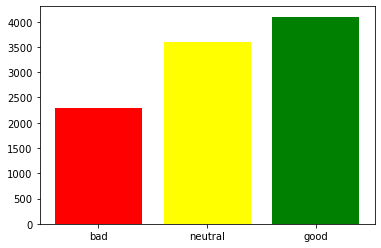

In [20]:
rule_1 = {'bad_sentences':0, 'neutral_sentences':0,'good_sentences':0}
for sentence in sentence_list:
    if sentence.estimation_1 < 0:
        rule_1['bad_sentences'] += 1
    elif sentence.estimation_1 == 0:
        rule_1['neutral_sentences'] += 1
    else :
        rule_1['good_sentences'] += 1
print(rule_1)

with open('classifications.txt.', 'a+', encoding='UTF8') as file:
    print('Rule 1:', file= file)
    for classification, number in rule_1.items():
        print('%s - %d - %.3f%%' % (classification, number, 100*number/total_twits), file= file)
    print(file=file)
plt.bar(x=[-1,0,1], height = rule_1.values(), align ='center', color=['red', 'yellow', 'green'],
        tick_label = ['bad', 'neutral', 'good'])

{'bad_sentences': 242, 'neutral_sentences': 9476, 'good_sentences': 282}


<BarContainer object of 3 artists>

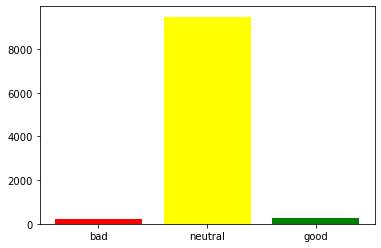

In [21]:
rule_2 = {'bad_sentences':0, 'neutral_sentences':0,'good_sentences':0}
for sentence in sentence_list:
    if sentence.estimation_2 < 0:
        rule_2['bad_sentences'] += 1
    elif sentence.estimation_2 == 0:
        rule_2['neutral_sentences'] += 1
    else :
        rule_2['good_sentences'] += 1
print(rule_2)

with open('classifications.txt.', 'a+', encoding='UTF8') as file:
    print('Rule 2:', file= file)
    for classification, number in rule_2.items():
        print('%s - %d - %.3f%%' % (classification, number, 100*number/total_twits), file= file)
    print(file=file)
plt.bar(x=[-1,0,1], height = rule_2.values(), align ='center', color=['red', 'yellow', 'green'],
        tick_label = ['bad', 'neutral', 'good'])

{'bad_sentences': 1071, 'neutral_sentences': 6086, 'good_sentences': 2843}


<BarContainer object of 3 artists>

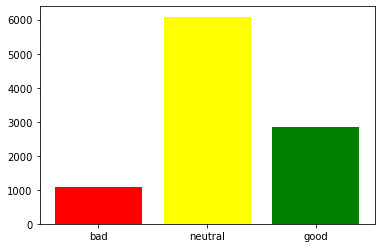

In [22]:
rule_3 = {'bad_sentences':0, 'neutral_sentences':0,'good_sentences':0}
for sentence in sentence_list:
    if sentence.estimation_3 < 0:
        rule_3['bad_sentences'] += 1
    elif sentence.estimation_3 == 0:
        rule_3['neutral_sentences'] += 1
    else :
        rule_3['good_sentences'] += 1
print(rule_3)

with open('classifications.txt.', 'a+', encoding='UTF8') as file:
    print('Rule 3:', file= file)
    for classification, number in rule_3.items():
        print('%s - %d - %.3f%%' % (classification, number, 100*number/total_twits), file= file)
    print(file=file)
plt.bar(x=[-1,0,1], height = rule_3.values(), align ='center', color=['red', 'yellow', 'green'],
        tick_label = ['bad', 'neutral', 'good'])

{'bad_sentences': 1123, 'neutral_sentences': 5881, 'good_sentences': 2996}


<BarContainer object of 3 artists>

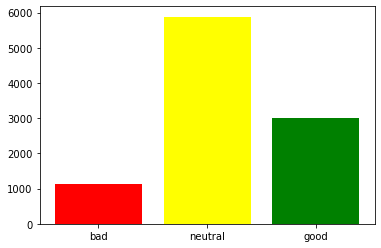

In [23]:
rule_4 = {'bad_sentences':0, 'neutral_sentences':0,'good_sentences':0}
for sentence in sentence_list:
    if sentence.estimation_4 < 0:
        rule_4['bad_sentences'] += 1
    elif sentence.estimation_4 == 0:
        rule_4['neutral_sentences'] += 1
    else :
        rule_4['good_sentences'] += 1
print(rule_4)

with open('classifications.txt.', 'a+', encoding='UTF8') as file:
    print('Rule 4:', file= file)
    for classification, number in rule_4.items():
        print('%s - %d - %.3f%%' % (classification, number, 100*number/total_twits), file= file)
    print(file=file)
plt.bar(x=[-1,0,1], height = rule_4.values(), align ='center', color=['red', 'yellow', 'green'],
        tick_label = ['bad', 'neutral', 'good'])

5. Части речи. (Достроить 2 графика)

In [24]:
possitive_list = []
negative_list = []
with open('estimations.txt', encoding='UTF8') as file:
    for line in file:
        line = line.strip().split()
        word = line[0]
        word_estimation = int(line[1])
        if morph.tag(word)[0].POS == 'ADJF':
            if word_estimation == 1 and len(possitive_list) < 5:
                possitive_list.append(word)
            if word_estimation == -1 and len(negative_list) < 5:
                negative_list.append(word)
with open('adjectives.txt.', 'w', encoding='UTF8') as file:
    print('Top-5 Positive:', file= file)
    for word in possitive_list:
        print('%s - %d - %.3f%%' % (word, freq_in_twits[word], 100*freq_in_twits[word]/total_twits), file= file)
    print(file= file)
    
    print('Top-5 Negative:', file= file)
    for word in negative_list:
        print('%s - %d - %.3f%%' % (word, freq_in_twits[word], 100*freq_in_twits[word]/total_twits), file= file)
    print(file= file)

In [25]:
# # set width of bar
# barWidth = 0.4
 
# # set height of bar
# bars_negative = list(map(lambda x: freq_in_twits[x], negative_list))
# bars_possitive = list(map(lambda x: freq_in_twits[x], possitive_list))

# print(bars_negative)
# print(bars_possitive)

# # Set position of bar on X axis
# r1 = np.arange(len(bars1))
# r2 = [x + barWidth for x in r1]

# # Make the plot
# plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='Top-5-negative')
# plt.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', label='Top-5-possitive')
 
# # Add xticks on the middle of the group bars
# #plt.xlabel('', fontweight='bold')
# plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5'])
 
# # Create legend & Show graphic
# plt.legend()
# plt.show()

   Semantics    Top  Frequency        Word
0   negative  Top-1        323     обидный
1   negative  Top-2         58  кривоногий
2   negative  Top-3         55      плохой
3   negative  Top-4         51   виноватый
4   negative  Top-5         49    грустный
5  possitive  Top-1       1073     хороший
6  possitive  Top-2        268   достойный
7  possitive  Top-3        158     сильный
8  possitive  Top-4        124  прекрасный
9  possitive  Top-5         96    красивый


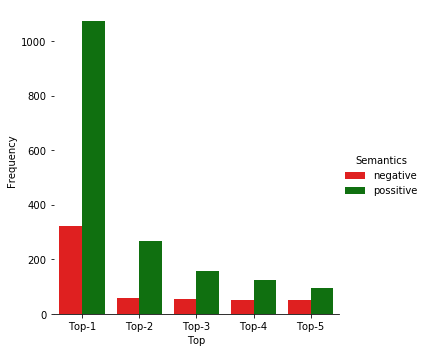

In [26]:
raw_data = {'Top':['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5']*2,
           'Semantics':['negative']*5 + ['possitive']*5,
           'Frequency':list(map(lambda x: freq_in_twits[x], negative_list)) + list(map(lambda x: freq_in_twits[x], possitive_list)),
           'Word':negative_list + possitive_list}
df = pd.DataFrame(raw_data, columns=['Semantics','Top','Frequency','Word'])
print(df)
g = sns.catplot(x="Top", y="Frequency", hue="Semantics", data=df,
                height=5, kind="bar", palette={'possitive':'g', 'negative':'r'})
g.despine(left=True)
g.set_ylabels("Frequency")

6. Оценить распределение положительных/отрицательных/нейтральных твитов по времени.

In [27]:
outset = set(sentence_list)
delta = timedelta(minutes = 30)
mintime = sentence_list[0].time
for sentence in sentence_list:
    mintime = min(mintime, sentence.time)
time = mintime + delta
delta = timedelta(minutes = 10)

time_list = [time]
possitive_time_1 = [0]
neutral_time_1 = [0]
negative_time_1 = [0]
sum_time = [0]

for sentence in sorted(sentence_list, key= lambda x: x.time):
    if sentence.time >= time:
        time += delta
        possitive_time_1.append(possitive_time_1[-1])
        neutral_time_1.append(neutral_time_1[-1])
        negative_time_1.append(negative_time_1[-1])
        sum_time.append(sum_time[-1])
        time_list.append(time)
    sum_time[-1] += 1
    if sentence.estimation_1 > 0:
        possitive_time_1[-1] += 1
    elif sentence.estimation_1 == 0:
        neutral_time_1[-1] += 1
    else:
        negative_time_1[-1] += 1
print(sum_time[-1] == total_twits)
with open('hours_1.txt','w', encoding='UTF8') as file:
    for possitive, neutral, negative, time, sumt in zip(possitive_time_1, neutral_time_1, negative_time_1, time_list, sum_time):
        print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits), file= file)
        #print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits))

True


In [28]:
outset = set(sentence_list)
delta = timedelta(minutes = 30)
mintime = sentence_list[0].time
for sentence in sentence_list:
    mintime = min(mintime, sentence.time)
time = mintime + delta
delta = timedelta(minutes = 10)

time_list = [time]
possitive_time_2 = [0]
neutral_time_2 = [0]
negative_time_2 = [0]
sum_time = [0]

for sentence in sorted(sentence_list, key= lambda x: x.time):
    if sentence.time >= time:
        time += delta
        possitive_time_2.append(possitive_time_2[-1])
        neutral_time_2.append(neutral_time_2[-1])
        negative_time_2.append(negative_time_2[-1])
        sum_time.append(sum_time[-1])
        time_list.append(time)
    sum_time[-1] += 1
    if sentence.estimation_2 > 0:
        possitive_time_2[-1] += 1
    elif sentence.estimation_2 == 0:
        neutral_time_2[-1] += 1
    else:
        negative_time_2[-1] += 1
print(sum_time[-1] == total_twits)
with open('hours_2.txt','w', encoding='UTF8') as file:
    for possitive, neutral, negative, time, sumt in zip(possitive_time_2, neutral_time_2, negative_time_2, time_list, sum_time):
        print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits), file= file)
        #print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits))

True


In [29]:
outset = set(sentence_list)
delta = timedelta(minutes = 30)
mintime = sentence_list[0].time
for sentence in sentence_list:
    mintime = min(mintime, sentence.time)
time = mintime + delta
delta = timedelta(minutes = 10)

time_list = [time]
possitive_time_3 = [0]
neutral_time_3 = [0]
negative_time_3 = [0]
sum_time = [0]

for sentence in sorted(sentence_list, key= lambda x: x.time):
    if sentence.time >= time:
        time += delta
        possitive_time_3.append(possitive_time_3[-1])
        neutral_time_3.append(neutral_time_3[-1])
        negative_time_3.append(negative_time_3[-1])
        sum_time.append(sum_time[-1])
        time_list.append(time)
    sum_time[-1] += 1
    if sentence.estimation_3 > 0:
        possitive_time_3[-1] += 1
    elif sentence.estimation_3 == 0:
        neutral_time_3[-1] += 1
    else:
        negative_time_3[-1] += 1
print(sum_time[-1] == total_twits)
with open('hours_3.txt','w', encoding='UTF8') as file:
    for possitive, neutral, negative, time, sumt in zip(possitive_time_3, neutral_time_3, negative_time_3, time_list, sum_time):
        print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits), file= file)
        #print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits))

True


In [30]:
outset = set(sentence_list)
delta = timedelta(minutes = 30)
mintime = sentence_list[0].time
for sentence in sentence_list:
    mintime = min(mintime, sentence.time)
time = mintime + delta
delta = timedelta(minutes = 10)

time_list = [time]
possitive_time_4 = [0]
neutral_time_4 = [0]
negative_time_4 = [0]
sum_time = [0]

for sentence in sorted(sentence_list, key= lambda x: x.time):
    if sentence.time >= time:
        time += delta
        possitive_time_4.append(possitive_time_4[-1])
        neutral_time_4.append(neutral_time_4[-1])
        negative_time_4.append(negative_time_4[-1])
        sum_time.append(sum_time[-1])
        time_list.append(time)
    sum_time[-1] += 1
    if sentence.estimation_4 > 0:
        possitive_time_4[-1] += 1
    elif sentence.estimation_4 == 0:
        neutral_time_4[-1] += 1
    else:
        negative_time_4[-1] += 1
print(sum_time[-1] == total_twits)
with open('hours_4.txt','w', encoding='UTF8') as file:
    for possitive, neutral, negative, time, sumt in zip(possitive_time_4, neutral_time_4, negative_time_4, time_list, sum_time):
        print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits), file= file)
        #print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits))

True


c:\users\yakhtin leonid\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


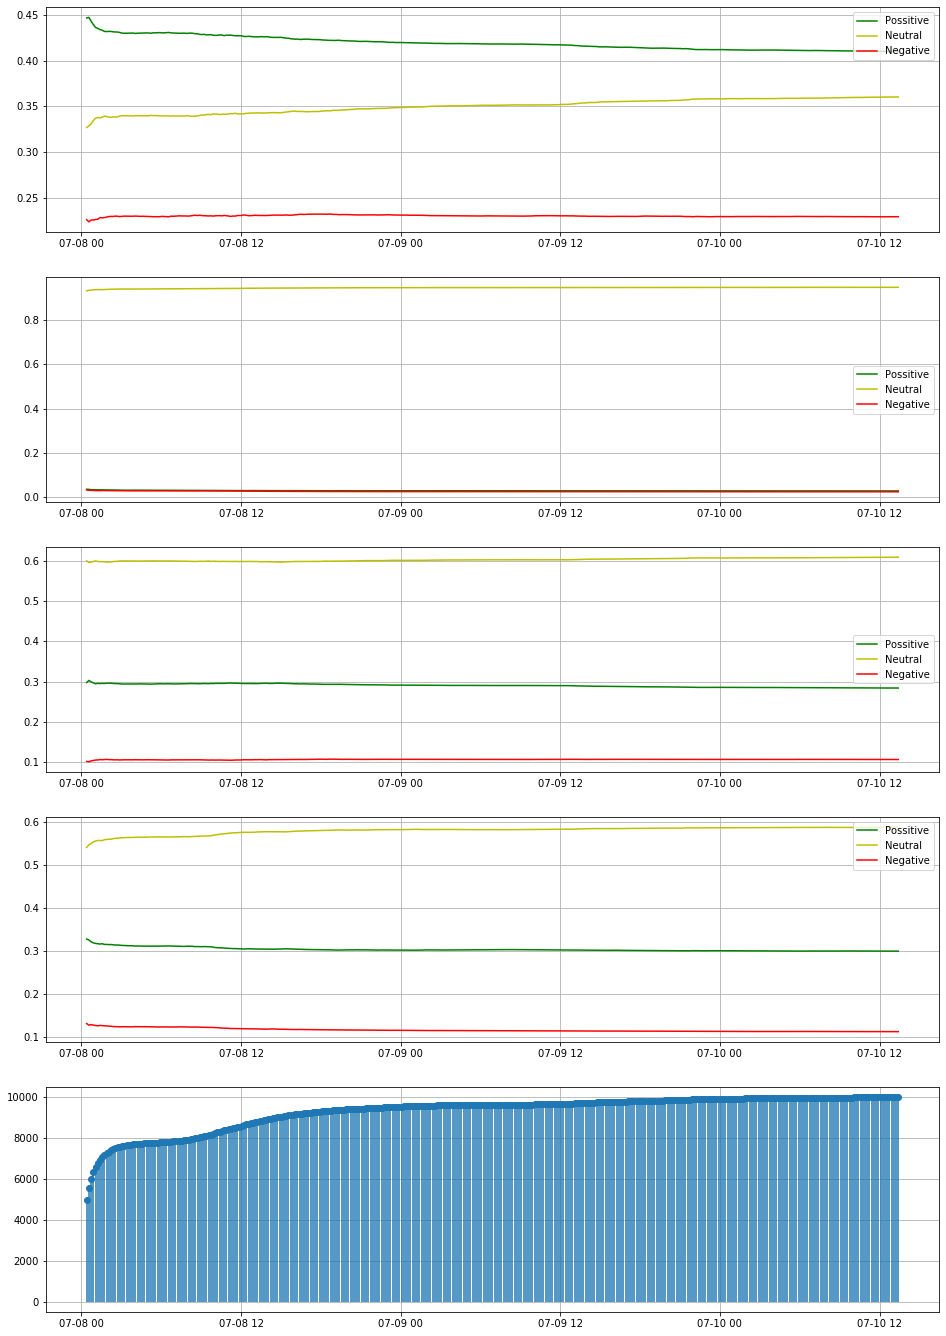

In [31]:
possitive_1_ax = [x/s for x, s in zip(possitive_time_1, sum_time)]
neutral_1_ax = [x/s for x, s in zip(neutral_time_1, sum_time)]
negative_1_ax = [x/s for x, s in zip(negative_time_1, sum_time)]

possitive_2_ax = [x/s for x, s in zip(possitive_time_2, sum_time)]
neutral_2_ax = [x/s for x, s in zip(neutral_time_2, sum_time)]
negative_2_ax = [x/s for x, s in zip(negative_time_2, sum_time)]

possitive_3_ax = [x/s for x, s in zip(possitive_time_3, sum_time)]
neutral_3_ax = [x/s for x, s in zip(neutral_time_3, sum_time)]
negative_3_ax = [x/s for x, s in zip(negative_time_3, sum_time)]

possitive_4_ax = [x/s for x, s in zip(possitive_time_4, sum_time)]
neutral_4_ax = [x/s for x, s in zip(neutral_time_4, sum_time)]
negative_4_ax = [x/s for x, s in zip(negative_time_4, sum_time)]

fig, (ax1, ax2, ax3, ax4, ax) = plt.subplots(nrows = 5, ncols = 1, figsize = (16, 24))


ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
ax.grid(True)

ax1.plot(time_list, possitive_1_ax, 'g', time_list, neutral_1_ax, 'y', time_list, negative_1_ax, 'r', linestyle='solid') 
ax1.legend(('Possitive', 'Neutral', 'Negative'))
ax2.plot(time_list, possitive_2_ax, 'g', time_list, neutral_2_ax, 'y', time_list, negative_2_ax, 'r', linestyle='solid')
ax2.legend(('Possitive', 'Neutral', 'Negative'))
ax3.plot(time_list, possitive_3_ax, 'g', time_list, neutral_3_ax, 'y', time_list, negative_3_ax, 'r', linestyle='solid')
ax3.legend(('Possitive', 'Neutral', 'Negative'))
ax4.plot(time_list, possitive_4_ax, 'g', time_list, neutral_4_ax, 'y', time_list, negative_4_ax, 'r', linestyle='solid')
ax4.legend(('Possitive', 'Neutral', 'Negative'))

ax.stem(time_list, sum_time, label="Number of tweets", basefmt="None", use_line_collection=True)

plt.show()

7*. ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ. Определение точности эмпирической оценки твитов.

In [32]:
empirical_estimation_1 = {}
accuracy = 0

for word in freq_in_twits:
    empirical_estimation_1[word] = 0

for sentence in sentence_list:
    for word, freq in sentence.used_words.items():
        empirical_estimation_1[word] += sentence.estimation_1*freq

for word in freq_in_twits:
    empirical_estimation_1[word] /= freq_in_twits[word]

deviation = {}

for word in freq_in_twits:
    deviation[word] = abs(word_estimations[word] - empirical_estimation_1[word])
    if deviation[word] < 1 or (word_estimations[word] > 0 and empirical_estimation_1[word] > 0) or (word_estimations[word] < 0 and empirical_estimation_1[word] < 0):
        accuracy += 1

#deviation_list = sorted(deviation.items(), key= lambda x: x[1], reverse=False)
deviation_list = sorted(deviation, key= lambda x: deviation[x], reverse=False)

with open('estimation_check_1.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Closest:", file= file)
    for word in deviation_list[:5]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation_1[word]), file= file)
    print(file= file)
    
    print("Top-5 Furthest:", file= file)
    for word in deviation_list[-1:-6:-1]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation_1[word]), file= file)
    print(file= file)
    
    print("Estimation accuracy: %.3f%%" % (100*accuracy/len(freq_in_twits)), file=file)
    
with open('estimation_check_1.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Closest:

он   0.00   0.00

найти   0.00   0.00

хобби   0.00   0.00

домогаться   0.00   0.00

заесть   0.00   0.00



Top-5 Furthest:

ржач   0.00   -5.00

аут   0.00   4.00

оля-оля   0.00   3.00

грандиозный   0.00   3.00

ніколя   0.00   3.00



Estimation accuracy: 59.678%



In [33]:
#freq_in_twits

In [34]:
empirical_estimation_2 = {}
accuracy = 0

for word in freq_in_twits:
    empirical_estimation_2[word] = 0

for sentence in sentence_list:
    for word, freq in sentence.used_words.items():
        empirical_estimation_2[word] += sentence.estimation_2*freq

for word in freq_in_twits:
    empirical_estimation_2[word] /= freq_in_twits[word]

deviation = {}

for word in freq_in_twits:
    deviation[word] = abs(word_estimations[word] - empirical_estimation_2[word])
    if deviation[word] < 1 or (word_estimations[word] > 0 and empirical_estimation_2[word] > 0) or (word_estimations[word] < 0 and empirical_estimation_2[word] < 0):
        accuracy += 1

#deviation_list = sorted(deviation.items(), key= lambda x: x[1], reverse=False)
deviation_list = sorted(deviation, key= lambda x: deviation[x], reverse=False)

with open('estimation_check_2.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Closest:", file= file)
    for word in deviation_list[:5]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation_2[word]), file= file)
    print(file= file)
    
    print("Top-5 Furthest:", file= file)
    for word in deviation_list[-1:-6:-1]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation_2[word]), file= file)
    print(file= file)
    
    print("Estimation accuracy: %.3f%%" % (100*accuracy/len(freq_in_twits)), file=file)
    
with open('estimation_check_2.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Closest:

заявить   0.00   0.00

снимать   0.00   0.00

ответственность   0.00   0.00

забитый   0.00   0.00

пенальти   0.00   0.00



Top-5 Furthest:

позорный   -1.00   0.12

мор   -1.00   0.08

вытащить   1.00   -0.06

охуенно   1.00   -0.06

жаль   -1.00   0.02



Estimation accuracy: 95.020%



In [35]:
empirical_estimation_3 = {}
accuracy = 0

for word in freq_in_twits:
    empirical_estimation_3[word] = 0

for sentence in sentence_list:
    for word, freq in sentence.used_words.items():
        empirical_estimation_3[word] += sentence.estimation_3*freq

for word in freq_in_twits:
    empirical_estimation_3[word] /= freq_in_twits[word]

deviation = {}

for word in freq_in_twits:
    deviation[word] = abs(word_estimations[word] - empirical_estimation_3[word])
    if deviation[word] < 1 or (word_estimations[word] > 0 and empirical_estimation_3[word] > 0) or (word_estimations[word] < 0 and empirical_estimation_3[word] < 0):
        accuracy += 1

#deviation_list = sorted(deviation.items(), key= lambda x: x[1], reverse=False)
deviation_list = sorted(deviation, key= lambda x: deviation[x], reverse=False)

with open('estimation_check_3.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Closest:", file= file)
    for word in deviation_list[:5]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation_3[word]), file= file)
    print(file= file)
    
    print("Top-5 Furthest:", file= file)
    for word in deviation_list[-1:-6:-1]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation_3[word]), file= file)
    print(file= file)
    
    print("Estimation accuracy: %.3f%%" % (100*accuracy/len(freq_in_twits)), file=file)
    
with open('estimation_check_3.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Closest:

видимо   0.00   0.00

найти   0.00   0.00

взаимопонимание   0.00   0.00

хобби   0.00   0.00

домогаться   0.00   0.00



Top-5 Furthest:

ржач   0.00   -5.00

аут   0.00   4.00

оля-оля   0.00   3.00

грандиозный   0.00   3.00

посрать   0.00   2.00



Estimation accuracy: 72.750%



In [36]:
empirical_estimation_4 = {}
accuracy = 0

for word in freq_in_twits:
    empirical_estimation_4[word] = 0

for sentence in sentence_list:
    for word, freq in sentence.used_words.items():
        empirical_estimation_4[word] += sentence.estimation_4*freq

for word in freq_in_twits:
    empirical_estimation_4[word] /= freq_in_twits[word]

deviation = {}

for word in freq_in_twits:
    deviation[word] = abs(word_estimations[word] - empirical_estimation_4[word])
    if deviation[word] < 1 or (word_estimations[word] > 0 and empirical_estimation_4[word] > 0) or (word_estimations[word] < 0 and empirical_estimation_4[word] < 0):
        accuracy += 1

#deviation_list = sorted(deviation.items(), key= lambda x: x[1], reverse=False)
deviation_list = sorted(deviation, key= lambda x: deviation[x], reverse=False)

with open('estimation_check_4.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Closest:", file= file)
    for word in deviation_list[:5]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation_4[word]), file= file)
    print(file= file)
    
    print("Top-5 Furthest:", file= file)
    for word in deviation_list[-1:-6:-1]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation_4[word]), file= file)
    print(file= file)
    
    print("Estimation accuracy: %.3f%%" % (100*accuracy/len(freq_in_twits)), file=file)
    
with open('estimation_check_4.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Closest:

заявить   0.00   0.00

помогать   0.00   0.00

найти   0.00   0.00

взаимопонимание   0.00   0.00

хобби   0.00   0.00



Top-5 Furthest:

аут   0.00   4.00

оля-оля   0.00   3.00

посрать   0.00   2.00

>россия   0.00   2.00

художник   0.00   2.00



Estimation accuracy: 86.773%



8*. ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ. Определить слова с самой положительной и отрицательной окраской.

In [37]:
empirical_estimation_list_1 = sorted(empirical_estimation_1.items(), key= lambda x: x[1])

with open('best_worst_1.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Most Negative:", file= file)
    for word, estimation in empirical_estimation_list_1[:5]:
        print(word, estimation, file= file)
    print(file= file)
    
    print("Top-5 Most Positive:", file= file)
    for word, estimation in empirical_estimation_list_1[-1:-6:-1]:
        print(word, estimation, file= file)

with open('best_worst_1.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Most Negative:

ржач -5.0

антуан -2.0

дурачок -2.0

200рубль -2.0

предоставить -2.0



Top-5 Most Positive:

аут 4.0

оля-оля 3.0

грандиозный 3.0

ніколя 3.0

распиздяй 2.0



   Semantics    Top  Frequency        Word
0   negative  Top-1       -5.0     обидный
1   negative  Top-2       -2.0  кривоногий
2   negative  Top-3       -2.0      плохой
3   negative  Top-4       -2.0   виноватый
4   negative  Top-5       -2.0    грустный
5  possitive  Top-1        4.0     хороший
6  possitive  Top-2        3.0   достойный
7  possitive  Top-3        3.0     сильный
8  possitive  Top-4        3.0  прекрасный
9  possitive  Top-5        2.0    красивый


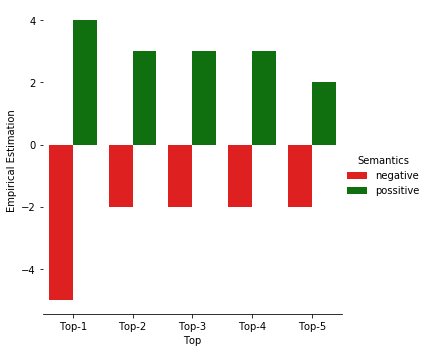

In [38]:
raw_data = {'Top':['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5']*2,
           'Semantics':['negative']*5 + ['possitive']*5,
           'Frequency':list(map(lambda x: x[1], empirical_estimation_list_1[:5])) + list(map(lambda x: x[1], empirical_estimation_list_1[-1:-6:-1])),
           'Word':negative_list + possitive_list}
df = pd.DataFrame(raw_data, columns=['Semantics','Top','Frequency','Word'])
print(df)
g = sns.catplot(x="Top", y="Frequency", hue="Semantics", data=df,
                height=5, kind="bar", palette={'possitive':'g', 'negative':'r'})
g.despine(left=True)
g.set_ylabels("Empirical Estimation")

In [39]:
empirical_estimation_list_2 = sorted(empirical_estimation_2.items(), key= lambda x: x[1])
with open('best_worst_2.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Most Negative:", file= file)
    for word, estimation in empirical_estimation_list_2[:5]:
        print(word, estimation, file= file)
    print(file= file)
    
    print("Top-5 Most Positive:", file= file)
    for word, estimation in empirical_estimation_list_2[-1:-6:-1]:
        print(word, estimation, file= file)

with open('best_worst_2.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Most Negative:

шах -1.0

реву- -1.0

перебивать -1.0

русиана -1.0

ебанарь -1.0



Top-5 Most Positive:

улыбаться 1.6666666666666667

хоратия 1.0

экранизация 1.0

чарли 1.0

пацаныыыы 1.0



   Semantics    Top  Frequency        Word
0   negative  Top-1  -1.000000     обидный
1   negative  Top-2  -1.000000  кривоногий
2   negative  Top-3  -1.000000      плохой
3   negative  Top-4  -1.000000   виноватый
4   negative  Top-5  -1.000000    грустный
5  possitive  Top-1   1.666667     хороший
6  possitive  Top-2   1.000000   достойный
7  possitive  Top-3   1.000000     сильный
8  possitive  Top-4   1.000000  прекрасный
9  possitive  Top-5   1.000000    красивый


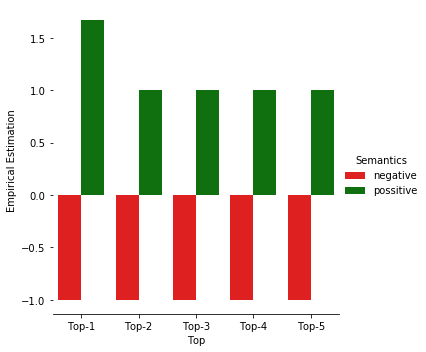

In [40]:
raw_data = {'Top':['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5']*2,
           'Semantics':['negative']*5 + ['possitive']*5,
           'Frequency':list(map(lambda x: x[1], empirical_estimation_list_2[:5])) + list(map(lambda x: x[1], empirical_estimation_list_2[-1:-6:-1])),
           'Word':negative_list + possitive_list}
df = pd.DataFrame(raw_data, columns=['Semantics','Top','Frequency','Word'])
print(df)
g = sns.catplot(x="Top", y="Frequency", hue="Semantics", data=df,
                height=5, kind="bar", palette={'possitive':'g', 'negative':'r'})
g.despine(left=True)
g.set_ylabels("Empirical Estimation")

In [41]:
empirical_estimation_list_3 = sorted(empirical_estimation_3.items(), key= lambda x: x[1])

with open('best_worst_3.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Most Negative:", file= file)
    for word, estimation in empirical_estimation_list_3[:5]:
        print(word, estimation, file= file)
    print(file= file)
    
    print("Top-5 Most Positive:", file= file)
    for word, estimation in empirical_estimation_list_3[-1:-6:-1]:
        print(word, estimation, file= file)

with open('best_worst_3.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Most Negative:

ржач -5.0

дурачок -2.0

пламенный -2.0

писд -2.0

«никакий -2.0



Top-5 Most Positive:

аут 4.0

оля-оля 3.0

грандиозный 3.0

посрать 2.0

>россия 2.0



   Semantics    Top  Frequency        Word
0   negative  Top-1       -5.0     обидный
1   negative  Top-2       -2.0  кривоногий
2   negative  Top-3       -2.0      плохой
3   negative  Top-4       -2.0   виноватый
4   negative  Top-5       -2.0    грустный
5  possitive  Top-1        4.0     хороший
6  possitive  Top-2        3.0   достойный
7  possitive  Top-3        3.0     сильный
8  possitive  Top-4        2.0  прекрасный
9  possitive  Top-5        2.0    красивый


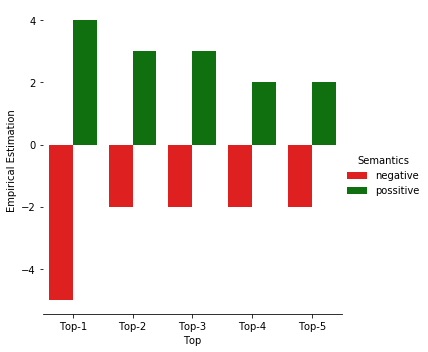

In [42]:
raw_data = {'Top':['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5']*2,
           'Semantics':['negative']*5 + ['possitive']*5,
           'Frequency':list(map(lambda x: x[1], empirical_estimation_list_3[:5])) + list(map(lambda x: x[1], empirical_estimation_list_3[-1:-6:-1])),
           'Word':negative_list + possitive_list}
df = pd.DataFrame(raw_data, columns=['Semantics','Top','Frequency','Word'])
print(df)
g = sns.catplot(x="Top", y="Frequency", hue="Semantics", data=df,
                height=5, kind="bar", palette={'possitive':'g', 'negative':'r'})
g.despine(left=True)
g.set_ylabels("Empirical Estimation")

In [43]:
empirical_estimation_list_4 = sorted(empirical_estimation_4.items(), key= lambda x: x[1])

with open('best_worst_4.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Most Negative:", file= file)
    for word, estimation in empirical_estimation_list_4[:5]:
        print(word, estimation, file= file)
    print(file= file)
    
    print("Top-5 Most Positive:", file= file)
    for word, estimation in empirical_estimation_list_4[-1:-6:-1]:
        print(word, estimation, file= file)

with open('best_worst_4.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Most Negative:

рыдать -1.1391304347826088

роберто -1.0

пеле -1.0

белград -1.0

патриотик -1.0



Top-5 Most Positive:

аут 4.0

оля-оля 3.0

посрать 2.0

>россия 2.0

художник 2.0



   Semantics    Top  Frequency        Word
0   negative  Top-1   -1.13913     обидный
1   negative  Top-2   -1.00000  кривоногий
2   negative  Top-3   -1.00000      плохой
3   negative  Top-4   -1.00000   виноватый
4   negative  Top-5   -1.00000    грустный
5  possitive  Top-1    4.00000     хороший
6  possitive  Top-2    3.00000   достойный
7  possitive  Top-3    2.00000     сильный
8  possitive  Top-4    2.00000  прекрасный
9  possitive  Top-5    2.00000    красивый


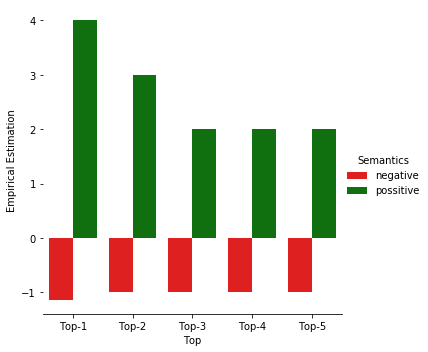

In [44]:
raw_data = {'Top':['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5']*2,
           'Semantics':['negative']*5 + ['possitive']*5,
           'Frequency':list(map(lambda x: x[1], empirical_estimation_list_4[:5])) + list(map(lambda x: x[1], empirical_estimation_list_4[-1:-6:-1])),
           'Word':negative_list + possitive_list}
df = pd.DataFrame(raw_data, columns=['Semantics','Top','Frequency','Word'])
print(df)
g = sns.catplot(x="Top", y="Frequency", hue="Semantics", data=df,
                height=5, kind="bar", palette={'possitive':'g', 'negative':'r'})
g.despine(left=True)
g.set_ylabels("Empirical Estimation")